In [1]:
# import sys
# sys.path.append('./algorithms/')
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from models.combined_actor_critic import ActorCritic, BiCameralActorCritic
from models.gating_network import GatingNetwork

## get left network
left_policy_net = torch.load('./logs/logs_CustomML10-v2/rl2_73__27:01_11:05:14/models/policy.pt')
left_encoder_net = torch.load('./logs/logs_CustomML10-v2/rl2_73__27:01_11:05:14/models/encoder.pt')
## get right network
right_policy_net = torch.load('./rl2_baseline/models/policy.pt')
right_encoder_net = torch.load('./rl2_baseline/models/encoder.pt')

bihem_ac = BiCameralActorCritic(left_policy_net, left_encoder_net, right_policy_net, right_encoder_net)

In [3]:
right_policy_net

Policy(
  (activation_function): Tanh()
  (actor_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (critic_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (critic_linear): Linear(in_features=256, out_features=1, bias=True)
  (dist): DiagGaussian(
    (fc_mean): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [4]:
from environments.custom_env_utils import prepare_base_envs, prepare_parallel_envs
from continualworld_utils.constants import TASK_SEQS
randomization = 'deterministic'
task_names = TASK_SEQS['CW10'][:2]
## initialise the envs
raw_train_envs = prepare_base_envs(task_names, randomization=randomization)
_, idx = np.unique(task_names, return_index=True)
unique_task_names = [task_names[i] for i in np.sort(idx)]
# self.env_id_to_name = {(i+1):env.name for i, env in enumerate(raw_train_envs)}
train_envs = prepare_parallel_envs(
    envs = raw_train_envs,
    steps_per_env=500,
    num_processes=1,
    gamma=0.99,
    normalise_rew=True,
    seed = 9,
    device=device
)

In [5]:
state = train_envs.reset()
left, right = bihem_ac.prior(1)
left_latent = torch.cat((left[0], left[1]), dim = -1)
right_latent = torch.cat((right[0], right[1]), dim = -1)

In [7]:
gn = bihem_ac.gating_network.to(device)
gating_values = gn(state[None,:,:].to(device), (left_latent.to(device), right_latent.to(device)))

/home/grant/miniconda3/envs/varibad/lib/python3.9/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
gating_values[0]

tensor([[0.5187, 0.4921]], device='cuda:0', grad_fn=<SelectBackward>)

In [24]:
print(
    right_latent.size(),
    right_latent.size(),
    state.size(),
    torch.cat(
        (right_latent, left_latent, state[None,:,:]), dim = -1
    )
)

torch.Size([1, 1, 256]) torch.Size([1, 1, 256]) torch.Size([1, 40]) tensor([[[-2.4017e-04,  5.1367e-02,  4.4339e-02, -1.5962e-01,  1.1237e-02,
           2.4492e-03, -1.1189e-01, -7.1536e-02,  5.0797e-02,  4.4776e-02,
           2.6688e-02,  7.8135e-02,  8.1717e-02,  8.3646e-02, -1.4928e-01,
           1.1044e-02, -1.0770e-01, -1.1089e-02, -1.2875e-02,  3.3217e-02,
           3.6152e-02, -1.0173e-01, -1.1619e-01, -6.3350e-02, -7.8993e-02,
          -4.8228e-03,  7.4036e-03,  4.9068e-02, -1.0750e-01, -1.2795e-01,
          -5.5253e-03, -4.5906e-02,  8.0407e-03, -1.1706e-01,  2.6422e-02,
          -4.4605e-02,  9.8984e-02, -1.2867e-02, -1.1369e-02, -3.3017e-02,
          -1.2622e-02, -1.5123e-01,  8.5351e-02, -1.0601e-01,  6.8457e-02,
          -4.6723e-02, -3.7220e-02, -6.0374e-02, -4.6561e-02, -3.3369e-02,
          -4.8692e-02, -4.2278e-02,  8.8780e-02, -1.0738e-01, -7.5074e-03,
           2.6635e-02, -8.8171e-02, -5.9533e-02, -4.2181e-02,  2.0690e-02,
          -8.2940e-02, -1.0262e-

In [2]:
# get RL2 trained policy for example
RUN_FOLDER = './logs/logs_CustomML10-v2/rl2_73__27:01_11:05:14'
left_policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
left_encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [ ]:
## left ac
## right ac

In [17]:
dummy = encoder_net.prior(1)[-1]
actor_means = policy_net.dist.fc_mean(dummy + 0.1)

tensor([[[ 0.0928, -0.0057,  0.0487,  0.0588]]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [11]:
policy_net.dist.fc_mean

Linear(in_features=256, out_features=4, bias=True)

In [4]:
def weight_reset(m: nn.Module):
    # - check if the current module has reset_parameters & if it's callabed called it on m
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

# Applies fn recursively to every submodule see: https://pytorch.org/docs/stable/generated/torch.nn.Module.html
policy_net.apply(fn=weight_reset)

Policy(
  (activation_function): Tanh()
  (actor_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (critic_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (critic_linear): Linear(in_features=256, out_features=1, bias=True)
  (dist): DiagGaussian(
    (fc_mean): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [5]:
policy_net2 = torch.load(RUN_FOLDER + '/models/policy.pt')

In [15]:
for i in policy_net.named_parameters():
    print(i[0])

actor_layers.0.weight
actor_layers.0.bias
critic_layers.0.weight
critic_layers.0.bias
critic_linear.weight
critic_linear.bias
dist.logstd
dist.fc_mean.weight
dist.fc_mean.bias


In [18]:
### this might require some more thought
### need to make a feedforward policy class that has some of the policy features
### Try this later
class DummyEncoder:
    def __init__(self, latent_dim, hidden_size):
        self.latent_dim = latent_dim
        self.hidden_size = hidden_size

    def prior(self, num_processes):
        latent_sample = torch.zeros(1, num_processes, self.latent_dim)
        latent_mean = torch.zeros(1, num_processes, self.latent_dim)
        latent_logvar = torch.zeros(1, num_processes, self.latent_dim)
        hidden_state = torch.zeros(1, num_processes, self.hidden_size)
        return latent_sample, latent_mean, latent_logvar, hidden_state

    def __call__(self, action, next_state, rewards, hidden_state, sample=False, return_prior=False, detach_every=None):
        num_processes = hidden_state.size(1)
        latent_sample = torch.zeros(1, num_processes, self.latent_dim)
        latent_mean = torch.zeros(1, num_processes, self.latent_dim)
        latent_logvar = torch.zeros(1, num_processes, self.latent_dim)
        hidden_state = torch.zeros(1, num_processes, self.hidden_size)
        return latent_sample, latent_mean, latent_logvar, hidden_state
    



In [3]:
# from continualworld_utils.wrappers import RandomizationWrapper

TASK_SEQS = {
    "CW10": [
        "hammer-v2",
        "push-wall-v2",
        "faucet-close-v2",
        "push-back-v2",
        "stick-pull-v2",
        "handle-press-side-v2",
        "push-v2",
        "shelf-place-v2",
        "window-close-v2",
        "peg-unplug-side-v2",
    ],
}

TASK_SEQS["CW20"] = TASK_SEQS["CW10"] + TASK_SEQS["CW10"]

In [1]:
5e-3/5e-6

999.9999999999999

In [26]:
from algorithms.custom_storage import CustomOnlineStorage
from algorithms.custom_ppo import CustomPPO
from models.combined_actor_critic import ActorCritic

# num_processes = 4
# combined network with encoder + policy
# dummy_encoder = DummyEncoder(encoder_net.latent_dim, encoder_net.hidden_size)
# dummy_policy = policy_net
# dummy_policy.pass_latent_to_policy = False
# dummy_policy.pass_state_to_policy = True
# ac = ActorCritic(dummy_policy, dummy_encoder)
ac = ActorCritic(policy_net, encoder_net)
agent = CustomPPO(
    actor_critic=ac,
    value_loss_coef = 1,
    entropy_coef = 5e-3,
    policy_optimiser='adam',
    policy_anneal_lr=False,
    train_steps = 3, # do I even need this?
    lr = 5e-4,
    eps=1.0e-8, # for adam optimiser
    clip_param = 0.2,
    ppo_epoch = 16,
    num_mini_batch=5,
    use_huber_loss = False,
    use_clipped_value_loss=False,
    context_window=None
)



In [27]:
from continualworld_utils.constants import TASK_SEQS
from continuallearner import ContinualLearner
num_processes = 20
steps_per_env = 1000
rollout_len = 500
## effective steps_per_env = num_processes * steps_per_env = 20000

continual_learner = ContinualLearner(
    42,
    TASK_SEQS['CW10'][:1], 
    agent, 
    num_processes, 
    rollout_len,
    steps_per_env,
    True, # normalisation
    'test_logs',
    'dummy',
    gamma = 0.99,
    tau = 0.97,
    log_every = 5,
    randomization='deterministic'
)

Seeding random, torch, numpy.
Note that due to parallel processing results will be similar but not identical. Use only one process and set --deterministic_execution to True if you want identical results (only recommended for debugging).
logging under test_logs/dummy__21:01_10:44:18


In [28]:
continual_learner.train()

completed in 119.58942747116089


In [20]:
num_processes = 17
steps_per_env = 5000
rollout_len = 500
print(
    f"total steps: {num_processes * rollout_len * (steps_per_env / rollout_len) }"

)
print(
    steps_per_env % num_processes * rollout_len == 0,
    steps_per_env * num_processes > 0
)

total steps: 85000.0
False True


In [32]:
1e6%25

0.0

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
results = pd.read_csv('logs/continual_learning/CL_left_only_31:01_21:39:03/results.csv')
results.loc[:,'is_training_task'] = results.loc[:,'training_task'] == results.loc[:,'evaluation_task']
results.head()

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9,episode,is_training_task
0,hammer-v2,hammer-v2,0.0,10,0.889172,0.881191,0.883592,0.884260,0.884371,0.885419,0.887165,0.902861,0.906418,0.909246,9,True
1,hammer-v2,push-wall-v2,0.0,10,0.017544,0.006706,0.007950,0.009458,0.011276,0.013533,0.016425,0.020299,0.026043,0.035871,9,False
2,hammer-v2,faucet-close-v2,0.0,10,3.035291,2.615182,2.806041,2.963519,3.050475,3.091202,3.168847,3.239399,3.290715,3.322372,9,False
3,hammer-v2,push-back-v2,0.0,10,0.009299,0.005610,0.006459,0.007432,0.008482,0.009535,0.010539,0.011429,0.012127,0.012360,9,False
4,hammer-v2,stick-pull-v2,0.0,10,0.007719,0.004163,0.006039,0.006611,0.007543,0.008327,0.008969,0.009470,0.009716,0.010016,9,False


<Axes: xlabel='episode', ylabel='reward_mean'>

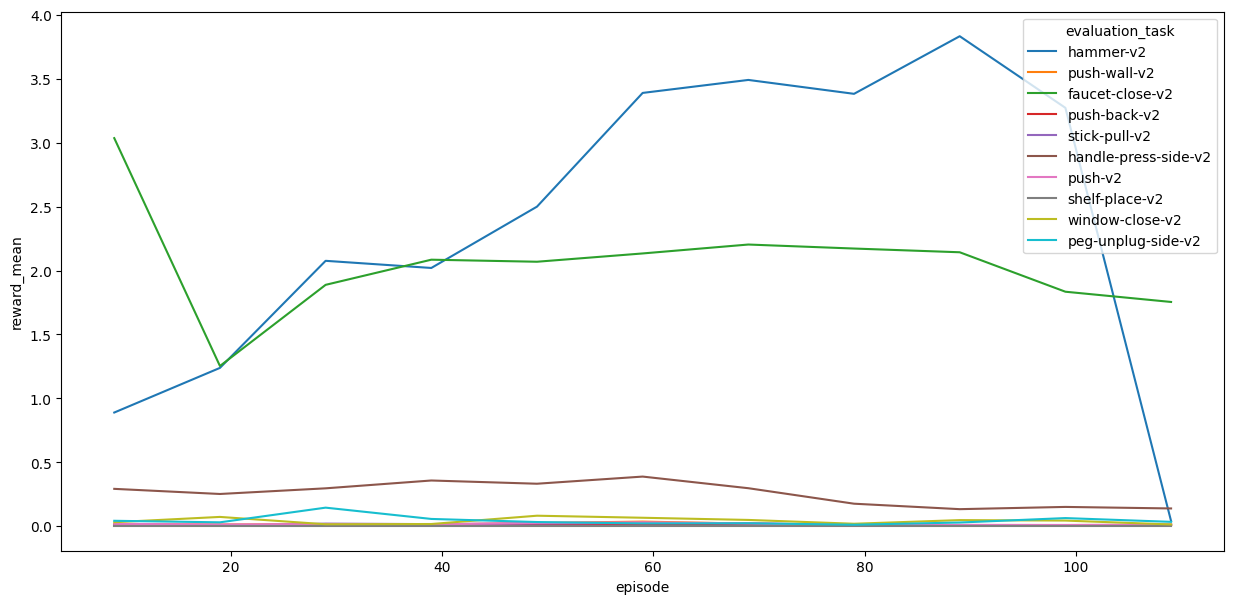

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(
    data = results,
    x = 'episode',
    y = 'reward_mean',
    hue = 'evaluation_task'
)

TypeError: 'NoneType' object is not iterable

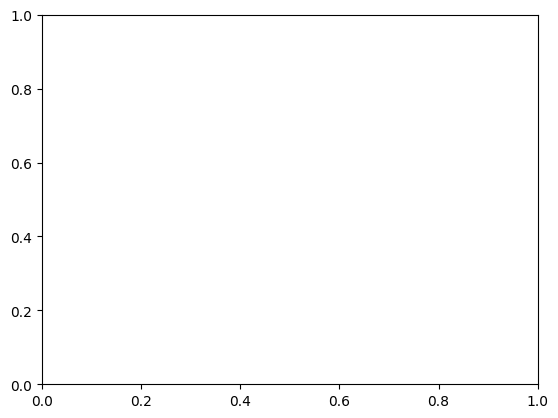

In [4]:
qtile_df = results.loc[:, ['q_' + str(i/10) for i in range(1, 10)] + ['episode','training_task']]\
    .melt(id_vars = ['episode', 'training_task'])

sns.lineplot(
    data= qtile_df.query('training_task=="hammer_v2"'),
    x = 'episode',
    y = 'value',
    hue = 'variable'
)

In [7]:
results = pd.read_csv('test_logs/dummy__20:01_15:59:01/results.csv')
results.loc[:,'is_training_task'] = results.loc[:,'training_task'] == results.loc[:,'evaluation_task']
results.head()

,training_task,evaluation_task,num_successes,num_episodes,reward_mean,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9,episode,is_training_task
0,hammer-v2,hammer-v2,0.0,10,0.808139,0.797541,0.799568,0.802094,0.805185,0.809023,0.813482,0.817681,0.822011,0.824941,4,True
1,hammer-v2,hammer-v2,0.0,10,0.815522,0.802312,0.803935,0.806668,0.812145,0.816690,0.821957,0.829092,0.831594,0.833981,9,True
2,hammer-v2,hammer-v2,0.0,10,1.075477,0.752363,0.765510,0.769011,0.791433,0.841098,1.002358,1.060368,1.394884,1.972556,14,True
3,hammer-v2,hammer-v2,0.0,10,1.467213,0.979290,1.063858,1.228914,1.328114,1.442907,1.567907,1.633997,1.908907,2.043712,19,True
4,hammer-v2,hammer-v2,0.0,10,1.599341,0.831989,0.864101,1.078993,1.295076,1.493371,1.877319,2.061319,2.261236,2.546574,24,True


<Axes: xlabel='episode', ylabel='value'>

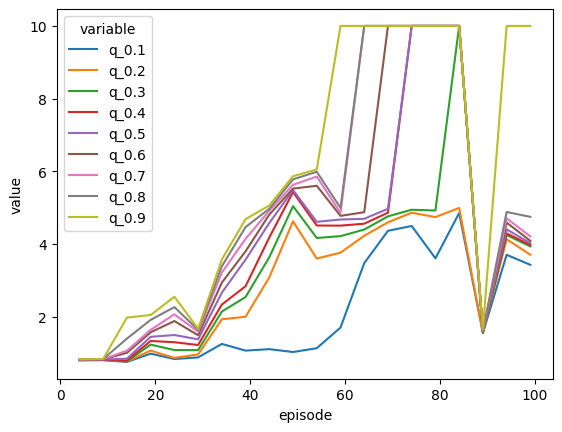

In [8]:
qtile_df = results.loc[:, ['q_' + str(i/10) for i in range(1, 10)] + ['episode','training_task']]\
    .melt(id_vars = ['episode', 'training_task'])

sns.lineplot(
    data= qtile_df,
    x = 'episode',
    y = 'value',
    hue = 'variable'
)

<Axes: xlabel='episode', ylabel='reward_mean'>

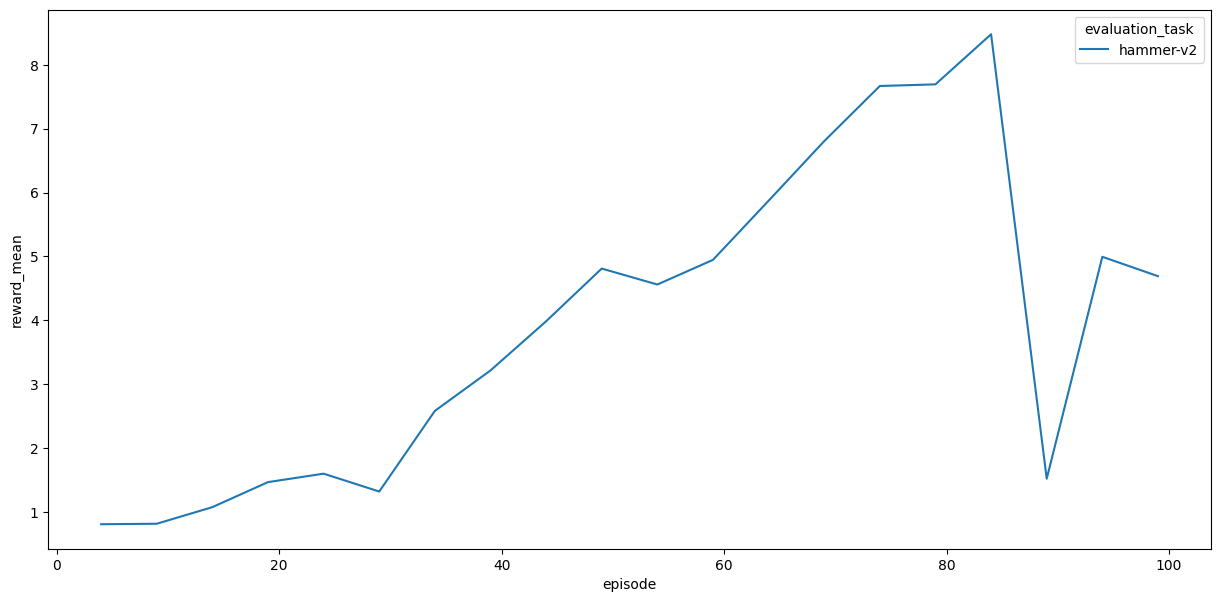

In [9]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(
    data = results,
    x = 'episode',
    y = 'reward_mean',
    hue = 'evaluation_task'
)

In [14]:
results['is_training_task2'] = (results.is_training_task |results.is_training_task.shift(1).fillna(False))

<Axes: xlabel='episode', ylabel='reward_mean'>

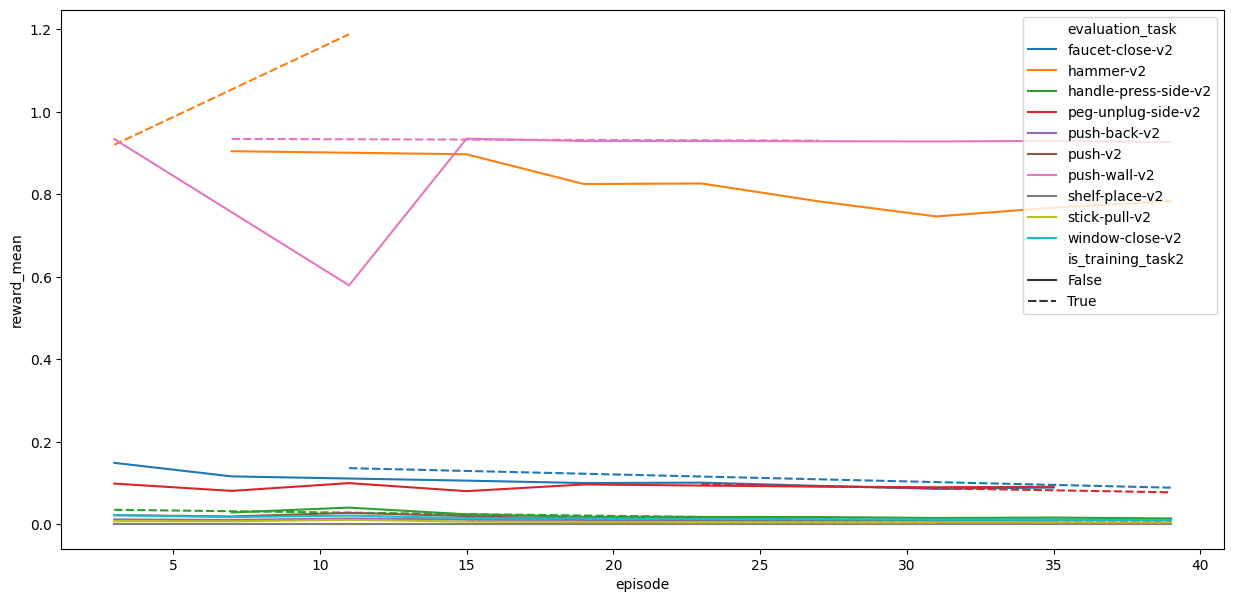

In [17]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(
    data = results,
    x = 'episode',
    y = 'reward_mean',
    hue = 'evaluation_task'
)

# sns.lineplot(
#     data = results.query('is_training_task2'),
#     x = 'episode',
#     y = 'reward_mean',
#     linewidth = 6
# )

<Axes: xlabel='episode', ylabel='success_rate'>

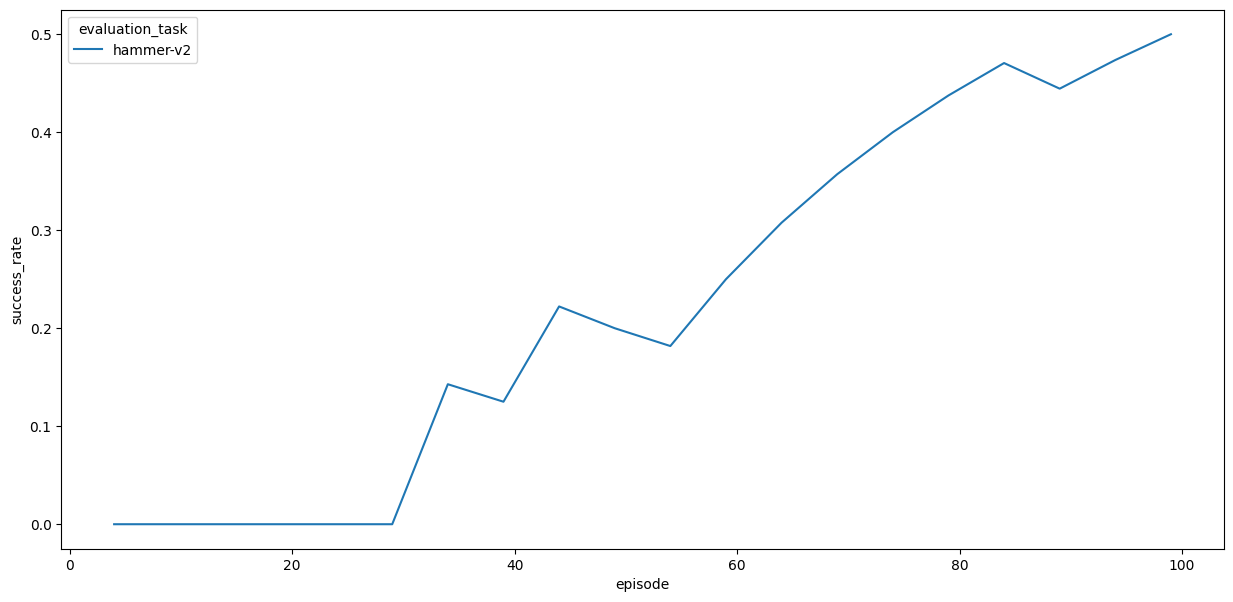

In [14]:
fig, ax = plt.subplots(figsize = (15, 7))
results['success_rate'] = results['num_successes'].cumsum() / results['num_episodes'].cumsum()
sns.lineplot(
    data = results,
    x = 'episode',
    y = 'success_rate',
    hue = 'evaluation_task'
)

# sns.lineplot(
#     data = results.query('training_task==evaluation_task'),
#     x = 'episode',
#     y = 'num_successes',
#     hue='evaluation_task',
#     linewidth = 6
# )

In [22]:
average_performance_df = results\
    .groupby(['episode', 'training_task'])\
    .agg({'reward_mean': 'mean', 'num_successes': 'mean'})\
    .reset_index()
average_performance_df

,episode,training_task,reward_mean,num_successes
0,4,hammer-v2,0.306701,0.4
1,9,hammer-v2,0.313565,0.4
2,14,hammer-v2,0.338779,0.3
3,19,hammer-v2,0.310690,0.0
4,24,push-wall-v2,0.367682,0.5
5,29,push-wall-v2,0.341313,0.1
6,34,push-wall-v2,0.330136,0.1
7,39,push-wall-v2,0.356731,0.1
8,44,faucet-close-v2,0.389015,0.2
9,49,faucet-close-v2,0.481074,0.5


<Axes: xlabel='episode', ylabel='num_successes'>

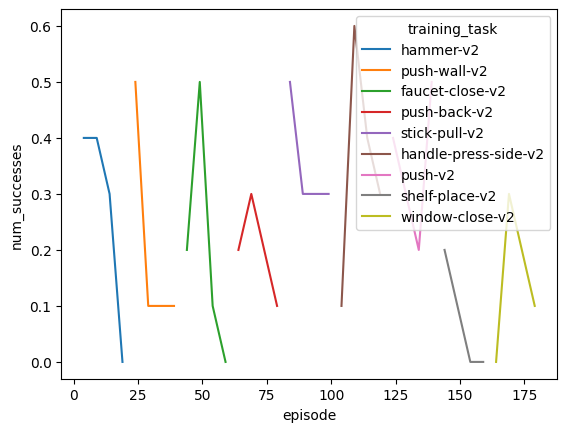

In [23]:
## try calculating metrics
## 1. average performance
## instead, lets count successes, and save number of episodes - then we calculate avg success
# average_performance_df = results\
#     .groupby('episode')\
#     .agg({'reward_mean': 'mean', 'num_successes':lambda x: x.num_successes})\
#     .reset_index()

sns.lineplot(
    data = average_performance_df,
    x = 'episode',
    y = 'num_successes',
    hue = 'training_task'
)

In [ ]:
## 2. Forward transfer
# look at CORA

In [ ]:
## 3. Forgetting
# success rate during training vs success rate at end
# need to calculate cumulative success rate

In [7]:
num_processes = 4
steps_per_env = 4000
rollout_len = 1000

print(
    steps_per_env % num_processes * rollout_len == 0,
    steps_per_env - num_processes * rollout_len >= 0
    )

True True


In [12]:
envs = prepare_parallel_envs(training_envs, steps_per_env, num_processes, device)
obs = envs.reset()
with torch.no_grad():
    _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_processes)

    ## TODO: set the 500 to some sort of variable (max episode len?)
    # assert len(storage.latent) == 0  # make sure we emptied buffers
    # print(f"saving hidden state to {i * 500}")

    latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)#.reshape(1, -1)



value, action = agent.act(obs, latent, None, None)
next_obs, reward, done, info = envs.step(action)

value, action = agent.act(obs, latent, None, None)
next_obs, reward2, done, info2 = envs.step(action)

In [13]:
successes = []
successes.append(torch.tensor([i['success'] for i in info]))
successes.append(torch.tensor([i['success'] for i in info2]))

In [22]:
torch.stack(successes).max(0)[0].sum() / num_processes

tensor(0.)

: 

In [41]:
num_processes = 4
steps_per_env = 2000
rollout_len = 500
## effective steps_per_env = num_processes * steps_per_env = 8000
envs = SubprocVecEnv([make_continual_env('continualMW-v0', **{'envs' : training_envs, 'steps_per_env': steps_per_env}) for i in range(num_processes)])
env = PyTorchVecEnvCont(envs, device)
storage = CustomOnlineStorage(
    rollout_len, num_processes, env.observation_space.shape[0]+1, 0, 0,
    env.action_space, ac.encoder.hidden_size, ac.encoder.latent_dim, False)
res = dict()
eps = 0
while env.get_env_attr('cur_step') < env.get_env_attr('steps_limit'):
    print(f"current step: {env.get_env_attr('cur_step')}; limit: {env.get_env_attr('steps_limit')}")
    step = 0

    
    # if I do this, I need to make sure my returns are calculated correctly / the done flags work
    # for i in range(num_episodes_per_update):
    obs = env.reset()
    current_task = env.get_env_attr("cur_seq_idx")
    episode_reward = 0
    done = [False for _ in range(num_processes)]
    # print(f"running episode {i}")
    ## get prior??? how frequent?
    # do at start of each episode for now
    with torch.no_grad():
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(num_processes)
        print(step)
        ## TODO: set the 500 to some sort of variable (max episode len?)
        assert len(storage.latent) == 0  # make sure we emptied buffers
        # print(f"saving hidden state to {i * 500}")
        storage.hidden_states[:1].copy_(hidden_state)
        latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1)#.reshape(1, -1)
        storage.latent.append(latent)

    while not all(done):
        value, action = agent.act(obs, latent, None, None)
        next_obs, reward, done, info = env.step(action)
        assert all(done) == any(done), "Metaworld envs should all end simultaneously"

        obs = next_obs
        episode_reward += reward.sum() / num_processes

        ## TODO: do I even need masks?
        # create mask for episode ends
        masks_done = torch.FloatTensor([[0.0] if _done else [1.0] for _done in done]).to(device)
        # bad_mask is true if episode ended because time limit was reached
        # don't care for metaworld
        bad_masks = torch.FloatTensor([[0.0] for _done in done]).to(device)

        # if done:
        #     print(f'{step}: done!')
        #     hidden_state = agent.actor_critic.encoder.reset_hidden(hidden_state, masks_done)
        # print(action.size(), obs.squeeze(0).size(), reward.squeeze(0).size(), hidden_state.size(), latent.size(), masks_done.size(), bad_masks.size())
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(action, obs, reward, hidden_state, return_prior = False)
        latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[None,:]#.reshape(1, -1)

        
        storage.next_state[step] = obs.clone()
        # print(action.squeeze(0).size(), obs.squeeze(0).size(), reward.squeeze(0).size(), hidden_state.size(), latent.size(), masks_done.size(), bad_masks.size())
        storage.insert(
            state=obs.squeeze(),
            belief=None,
            task=None,
            actions=action.double(),
            rewards_raw=reward.squeeze(0),
            rewards_normalised=reward.squeeze(0),#rew_normalised, don't use
            value_preds=value.squeeze(0),
            masks=masks_done.squeeze(0), # do I even need these?
            bad_masks=bad_masks.squeeze(0), 
            done=torch.from_numpy(done)[:,None].float(),
            hidden_states = hidden_state.squeeze(),
            latent = latent#.unsqueeze(1),
        )

        step += 1
        ### update
        # if step % num_updates ==0:

    # update at the end of each episode?
    res[eps] = (*agent.update(storage), current_task, episode_reward.cpu().detach().numpy())

    # # # should clear out old data
    storage.after_update()
    # update total steps
    # env.__setattr__('cur_step',  num_processes * rollout_len)
    eps+=1
    
        




current step: 0; limit: 10000
0
current step: 500; limit: 10000
0
current step: 1000; limit: 10000
0
current step: 1500; limit: 10000
0
current step: 2000; limit: 10000
0
current step: 2500; limit: 10000
0
current step: 3000; limit: 10000
0
current step: 3500; limit: 10000
0
current step: 4000; limit: 10000
0
current step: 4500; limit: 10000
0
current step: 5000; limit: 10000
0
current step: 5500; limit: 10000
0
current step: 6000; limit: 10000
0
current step: 6500; limit: 10000
0
current step: 7000; limit: 10000
0
current step: 7500; limit: 10000
0
current step: 8000; limit: 10000
0
current step: 8500; limit: 10000
0
current step: 9000; limit: 10000
0
current step: 9500; limit: 10000
0


In [50]:
import pandas as pd
# import seaborn as sns
new_res = {k:(*res[k][0:5], res[k][-1].cpu().detach().numpy() / 500) for k in res.keys()}
df = pd.DataFrame(new_res)
df.index = ['value_loss', 'actor_loss', 'entropy_loss', 'total_loss', 'task', 'episode_reward']
df.T.reset_index().melt(id_vars = ['task', 'index'])
# df.T.plot()

,task,index,variable,value
0,0.0,0,value_loss,0.237375
1,0.0,1,value_loss,0.238127
2,0.0,2,value_loss,0.270180
3,0.0,3,value_loss,0.173969
4,1.0,4,value_loss,0.746167
...,...,...,...,...
95,3.0,15,episode_reward,0.021147
96,4.0,16,episode_reward,0.135644
97,4.0,17,episode_reward,0.117424
98,4.0,18,episode_reward,0.146787


<Axes: xlabel='index', ylabel='value'>

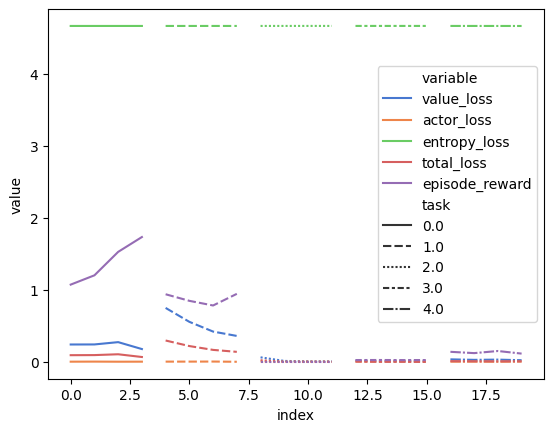

In [54]:
import seaborn as sns

sns.lineplot(
    data = df.T.reset_index().melt(id_vars = ['task', 'index']),
    x = 'index',
    y = 'value',
    hue = 'variable',
    palette = 'muted',
    style='task'


)